In [346]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier,export_graphviz 
from sklearn.model_selection import train_test_split
from statsmodels.discrete.discrete_model import Logit
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import recall_score, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm

In [347]:
data=pd.read_excel('Employee_attrition_HW3.xlsx')
data.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life_Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research_and_Development,8,1,Life_Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research_and_Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research_and_Development,3,4,Life_Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research_and_Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


In [348]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
Age                         1470 non-null int64
Attrition                   1470 non-null object
BusinessTravel              1470 non-null object
DailyRate                   1470 non-null int64
Department                  1470 non-null object
DistanceFromHome            1470 non-null int64
Education                   1470 non-null int64
EducationField              1470 non-null object
EmployeeCount               1470 non-null int64
EmployeeNumber              1470 non-null int64
EnvironmentSatisfaction     1470 non-null int64
Gender                      1470 non-null object
HourlyRate                  1470 non-null int64
JobInvolvement              1470 non-null int64
JobLevel                    1470 non-null int64
JobRole                     1470 non-null object
JobSatisfaction             1470 non-null int64
MaritalStatus               1470 non-null object
MonthlyIncome         

In [349]:
data.isnull().values.any() # no null variables

False

In [350]:
data_numeric=data.select_dtypes(exclude="object")
data_object=data.select_dtypes(include="object")

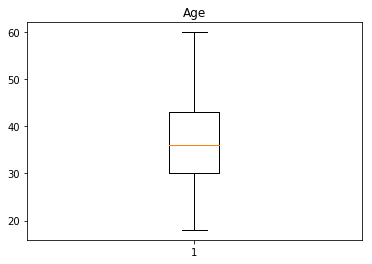

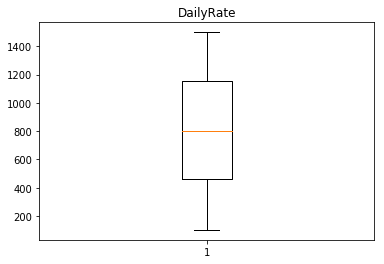

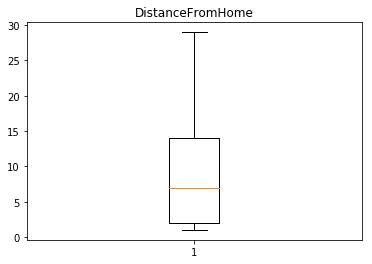

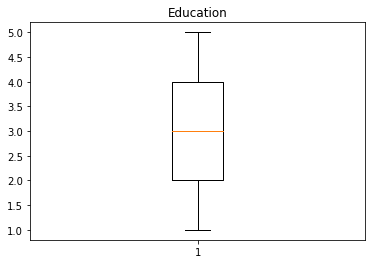

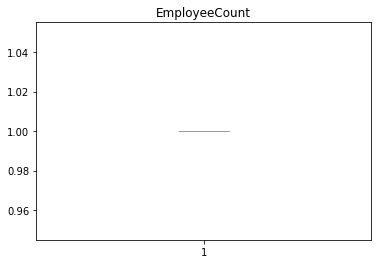

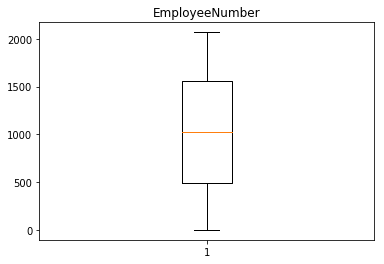

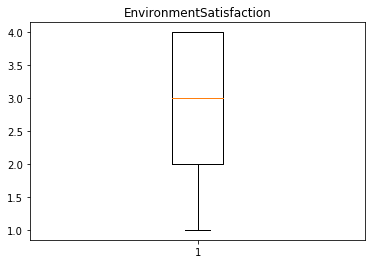

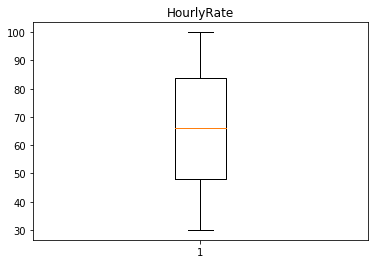

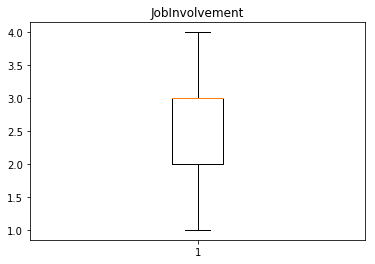

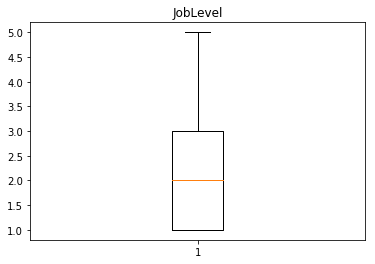

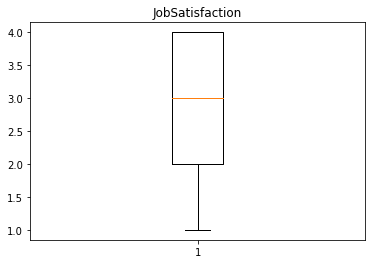

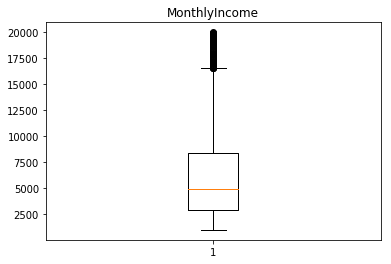

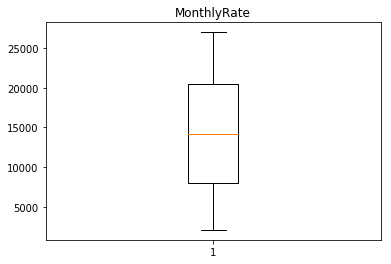

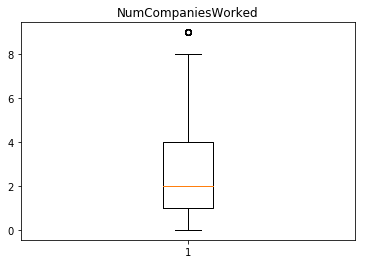

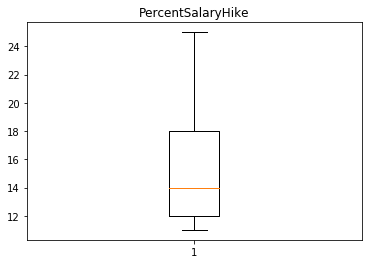

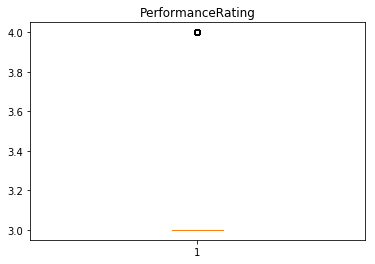

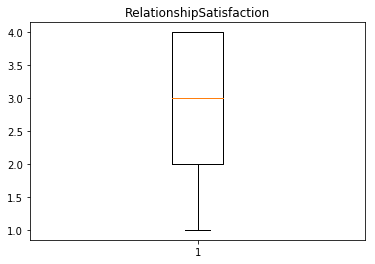

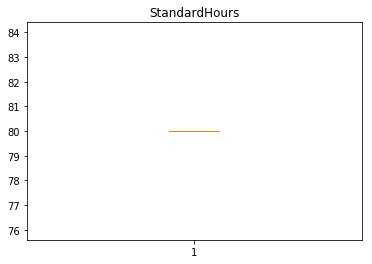

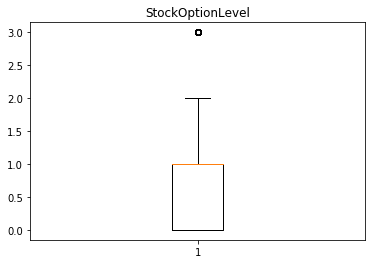

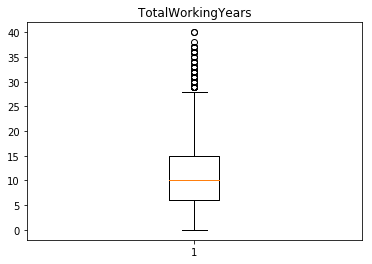

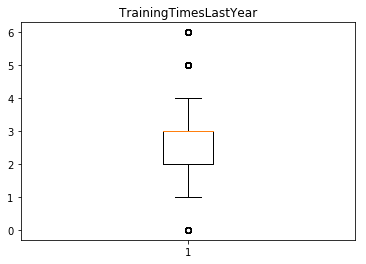

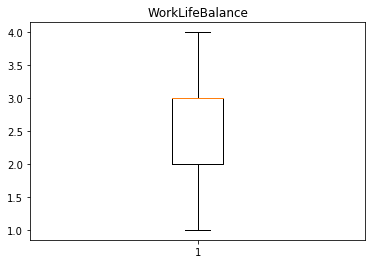

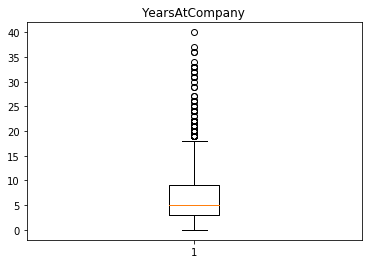

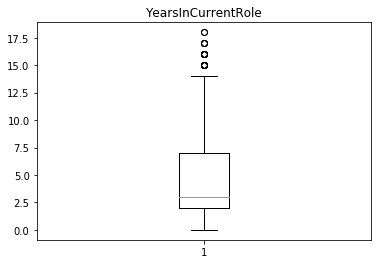

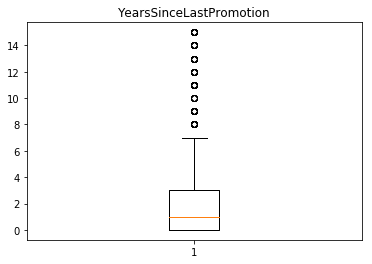

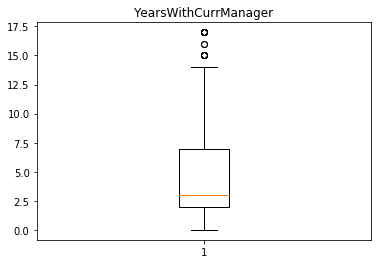

In [351]:
#box plots for identifying outliers
for i in data_numeric.columns:
  plt.boxplot(data_numeric[i])
  plt.title(i)
  plt.show()

Following variables have outliers-
    MonthlyIncome, 
    NumCompaniesWorked,
    PerformanceRating, 
    StockOptionLevel, 
    TotalWorkingYears,
    TrainingTimesLastYear,
    YearsAtCompany,
    YearsCurrentRole,
    YearsSinceLastPromotion,
    YearsWithCurrManager

In [352]:
data_numeric.var() #checking for 0 variance

Age                         8.345505e+01
DailyRate                   1.628196e+05
DistanceFromHome            6.572125e+01
Education                   1.048914e+00
EmployeeCount               1.233434e-32
EmployeeNumber              3.624333e+05
EnvironmentSatisfaction     1.194829e+00
HourlyRate                  4.132856e+02
JobInvolvement              5.063193e-01
JobLevel                    1.225316e+00
JobSatisfaction             1.216270e+00
MonthlyIncome               2.216486e+07
MonthlyRate                 5.066288e+07
NumCompaniesWorked          6.240049e+00
PercentSalaryHike           1.339514e+01
PerformanceRating           1.301936e-01
RelationshipSatisfaction    1.169013e+00
StandardHours               0.000000e+00
StockOptionLevel            7.260346e-01
TotalWorkingYears           6.054056e+01
TrainingTimesLastYear       1.662219e+00
WorkLifeBalance             4.991081e-01
YearsAtCompany              3.753431e+01
YearsInCurrentRole          1.312712e+01
YearsSinceLastPr

In [353]:
# drop standard hours column, as it has 0 variance (only 1 value=80)  
# and employee count column, as it has alsost 0 variance (only 1 value=1)
# drop employee number as it does not provide useful information
data_numeric= data_numeric.drop(['StandardHours','EmployeeCount','EmployeeNumber'],axis=1)

In [354]:
for i in data_object:
    print(data_object[i].unique())

['Yes' 'No']
['Travel_Rarely' 'Travel_Frequently' 'Non-Travel']
['Sales' 'Research_and_Development' 'Human_Resources']
['Life_Sciences' 'Other' 'Medical' 'Marketing' 'Technical_Degree'
 'Human_Resources']
['Female' 'Male']
['Sales_Executive' 'Research_Scientist' 'Laboratory_Technician'
 'Manufacturing_Director' 'Healthcare_Representative' 'Manager'
 'Sales_Representative' 'Research_Director' 'Human_Resources']
['Single' 'Married' 'Divorced']
['Y']
['Yes' 'No']


In [355]:
#drop "over 18" column as it has only one value=Y 
data_object= data_object.drop('Over18',axis=1) 

In [356]:
data_dummies=pd.get_dummies(data_object,prefix=data_object.columns,drop_first=True)


In [357]:
z=data_numeric.copy() ## now lets count number of outliers in each column
Q1 = z.quantile(0.25)
Q3 = z.quantile(0.75)
IQR = Q3 - Q1
fence_high=Q3 + 1.5 * IQR
fence_low=Q1 - 1.5 * IQR
print(((z < (Q1 - 1.5 * IQR)) | (z > (Q3 + 1.5 * IQR))).sum())


Age                           0
DailyRate                     0
DistanceFromHome              0
Education                     0
EnvironmentSatisfaction       0
HourlyRate                    0
JobInvolvement                0
JobLevel                      0
JobSatisfaction               0
MonthlyIncome               114
MonthlyRate                   0
NumCompaniesWorked           52
PercentSalaryHike             0
PerformanceRating           226
RelationshipSatisfaction      0
StockOptionLevel             85
TotalWorkingYears            63
TrainingTimesLastYear       238
WorkLifeBalance               0
YearsAtCompany              104
YearsInCurrentRole           21
YearsSinceLastPromotion     107
YearsWithCurrManager         14
dtype: int64


In [358]:
# I decided to drop outliers in "MonthlyIncome" as it can be enough for solving outliers' problem,
# as some of them can be in the same raws. Moreover, the other large outliers are in reality very close to each other, 
# such as PerformanceRating(226 outliers), which has two values 3 & 4, or TrainingTimesLastYear (238) values range from 0-6

In [359]:
# I choose only upper part, as from the graph outliers appear only in that region
data_numeric = data_numeric[data_numeric.MonthlyIncome <= fence_high.MonthlyIncome]

In [360]:
j=data_numeric.copy() ## now lets count number of outliers in each column after droping outliers of "MonthlyIncome"
q1 = j.quantile(0.25)
q3 = j.quantile(0.75)
iqr = q3 - q1

print(((j < (q1 - 1.5 * iqr)) | (j > (q3 + 1.5 * iqr))).sum())

Age                          24
DailyRate                     0
DistanceFromHome              0
Education                     0
EnvironmentSatisfaction       0
HourlyRate                    0
JobInvolvement                0
JobLevel                     61
JobSatisfaction               0
MonthlyIncome                73
MonthlyRate                   0
NumCompaniesWorked           47
PercentSalaryHike             0
PerformanceRating           210
RelationshipSatisfaction      0
StockOptionLevel             82
TotalWorkingYears            61
TrainingTimesLastYear       221
WorkLifeBalance               0
YearsAtCompany               52
YearsInCurrentRole            8
YearsSinceLastPromotion     173
YearsWithCurrManager          9
dtype: int64


In [361]:
data_numeric.shape

(1356, 23)

In [362]:
# we can see that outliers have decreassed

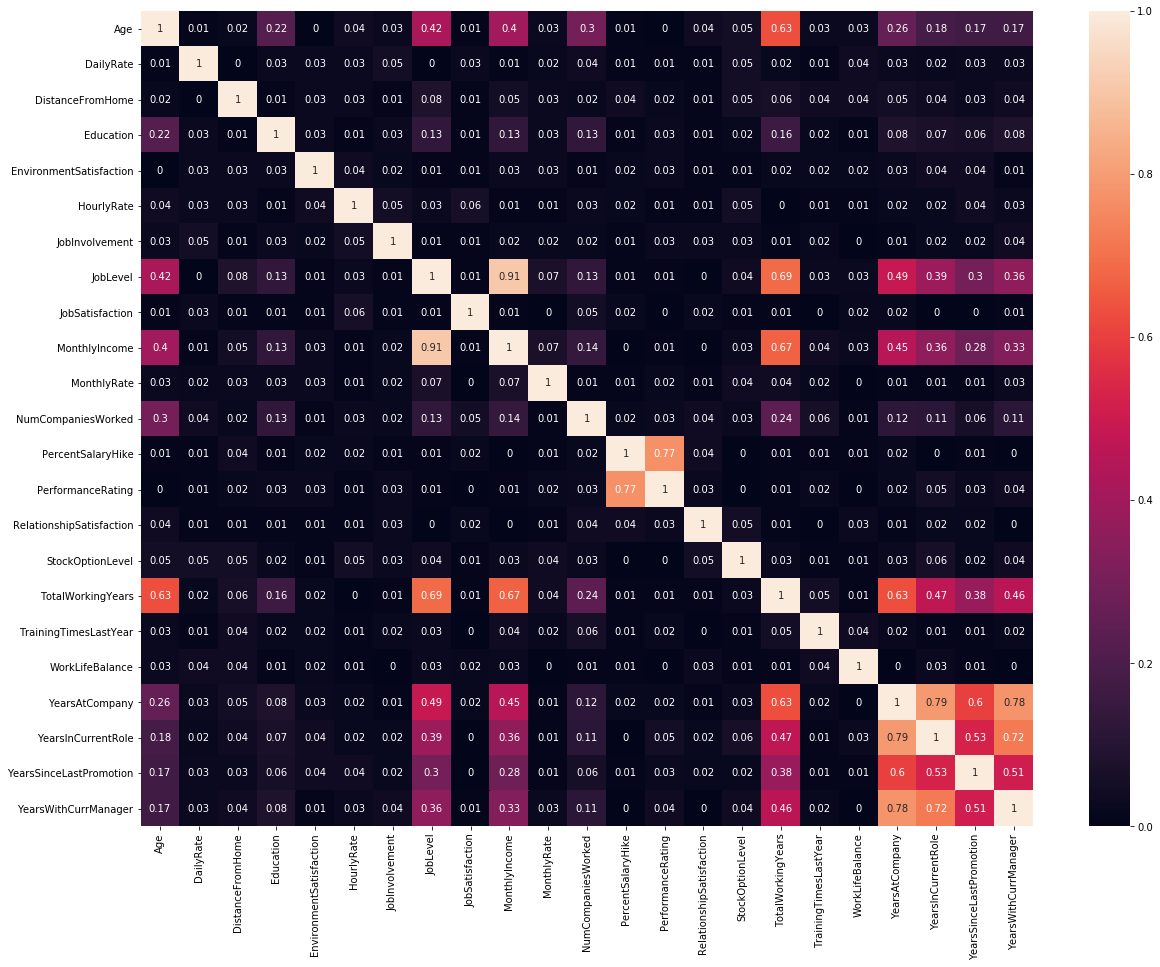

In [363]:
plt.figure(figsize=(20, 15))
sns.heatmap(data_numeric.corr().abs().round(2), annot=True)
plt.show()

In [364]:
# we can observe high multicollinearity (higher than 0.75) therefore I'll start dropping one of the high correlated variables

In [365]:
del data_numeric["JobLevel"]

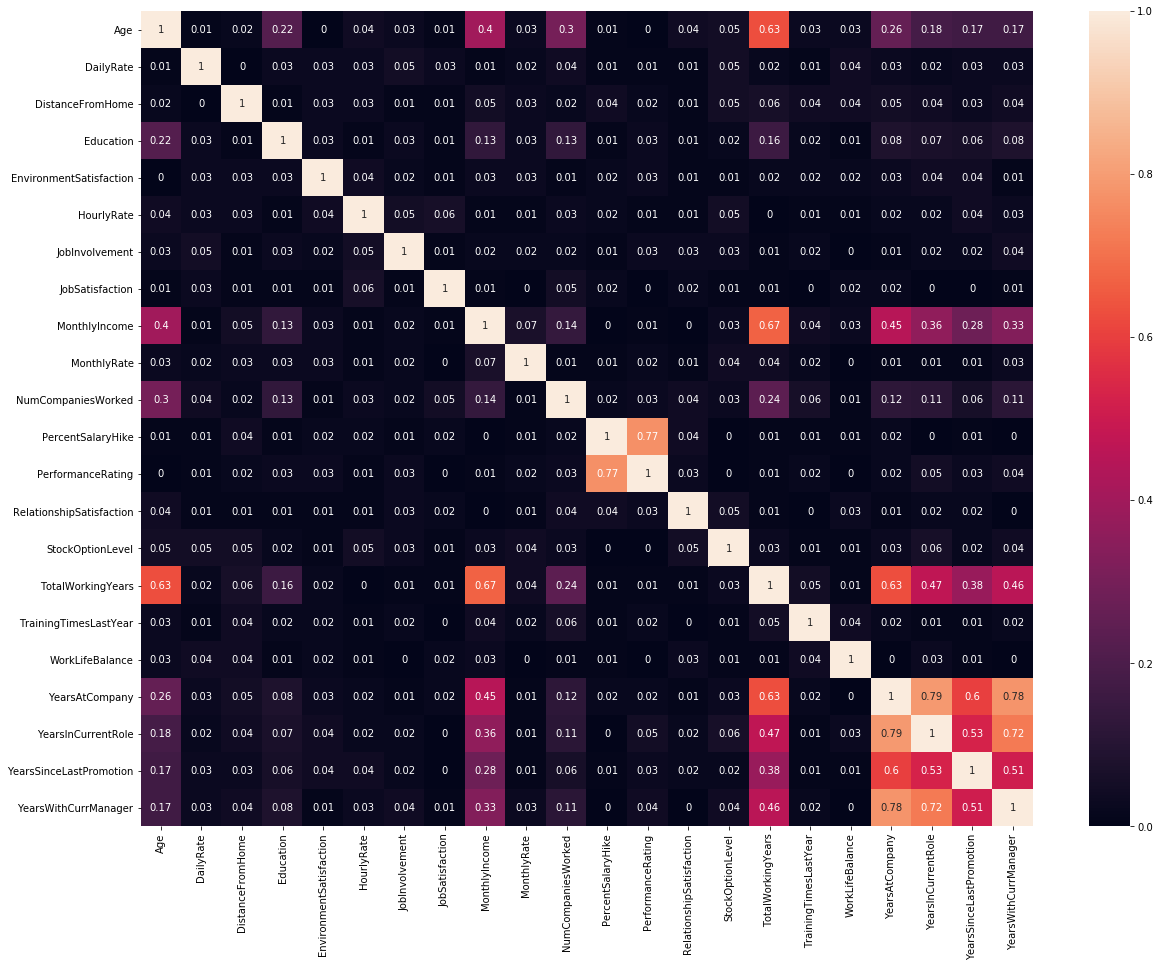

In [366]:
plt.figure(figsize=(20, 15))
sns.heatmap(data_numeric.corr().abs().round(2), annot=True)
plt.show()

In [367]:
#del data_numeric["JobLevel"] 
del data_numeric["YearsInCurrentRole"]

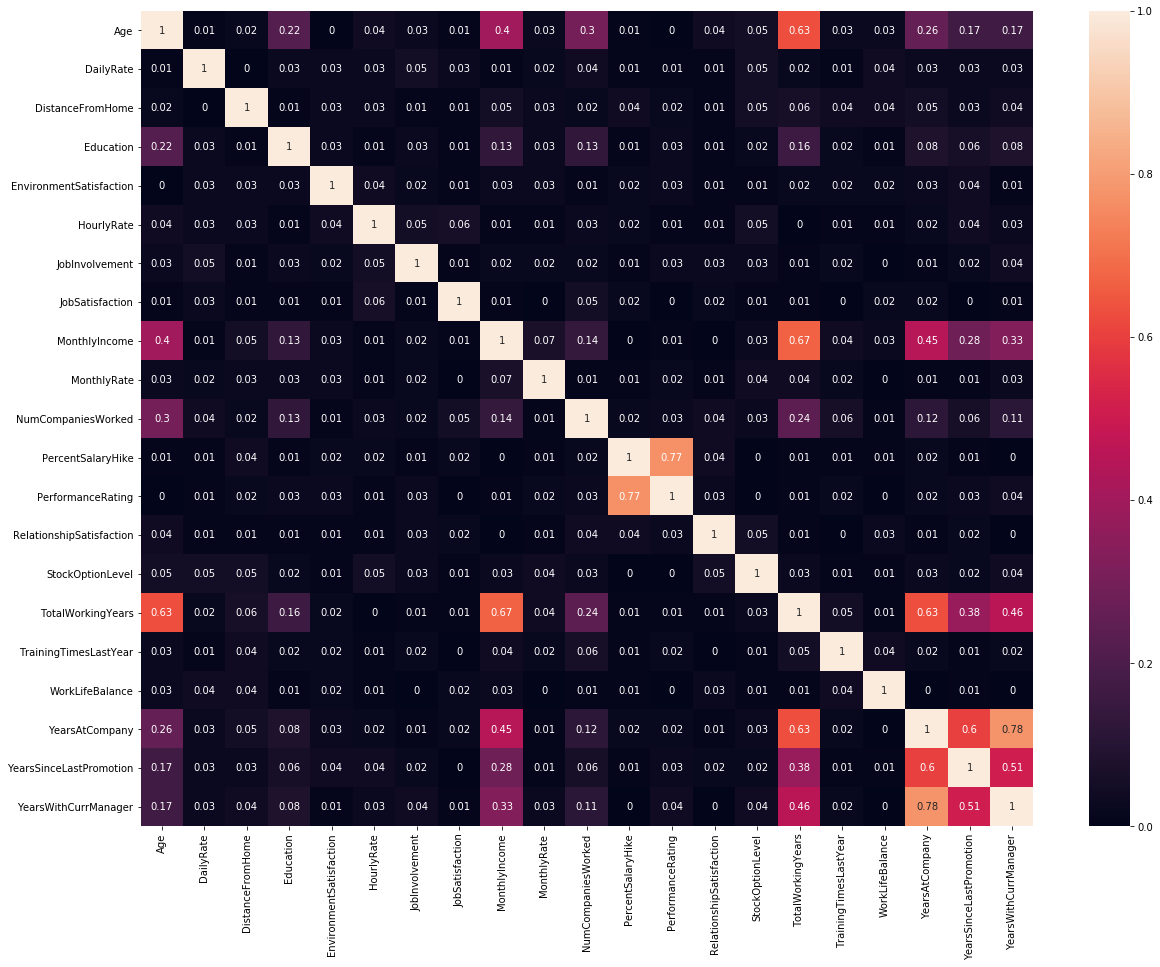

In [368]:
plt.figure(figsize=(20, 15))
sns.heatmap(data_numeric.corr().abs().round(2), annot=True)
plt.show()

In [369]:
del data_numeric["YearsAtCompany"]

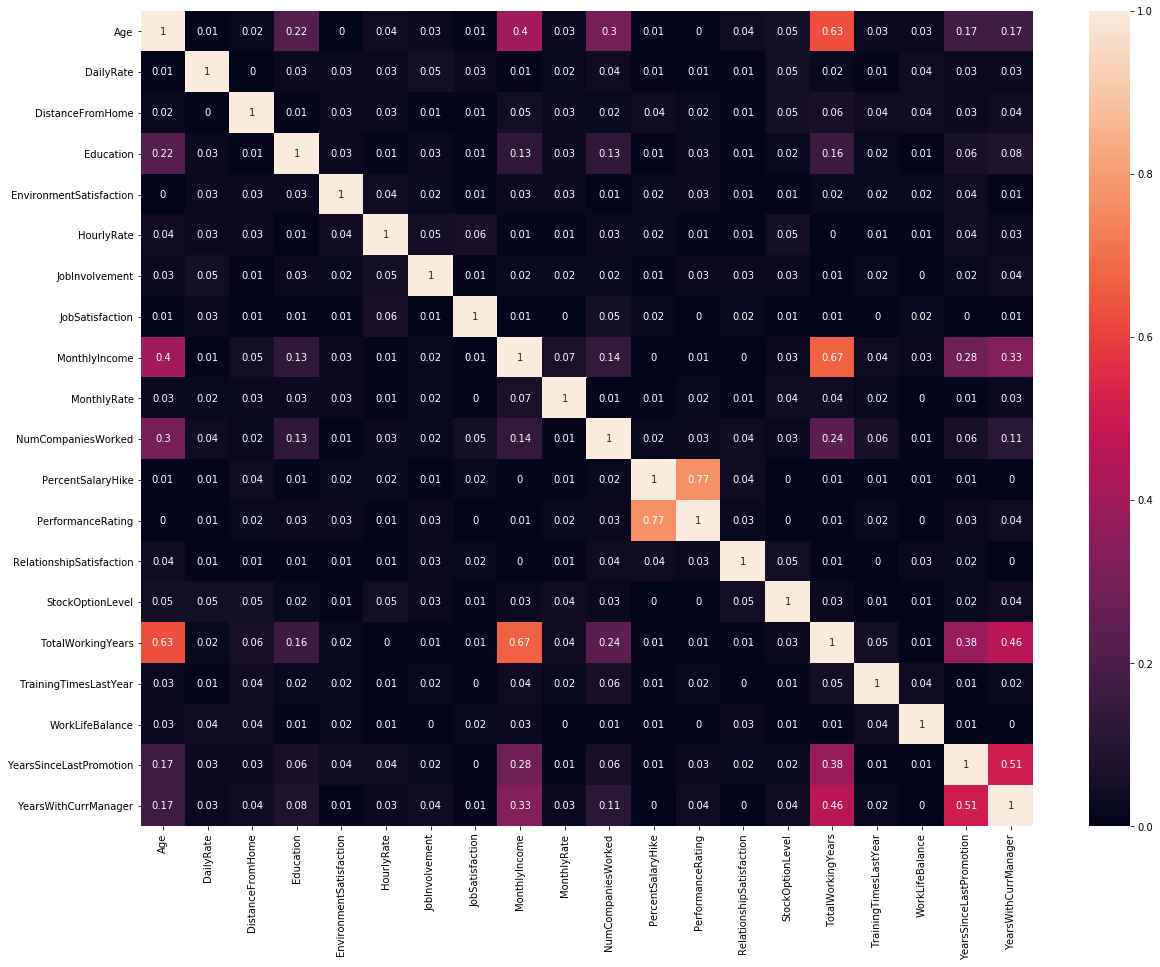

In [370]:
plt.figure(figsize=(20, 15))
sns.heatmap(data_numeric.corr().abs().round(2), annot=True)
plt.show()

In [371]:
del data_numeric["PercentSalaryHike"]

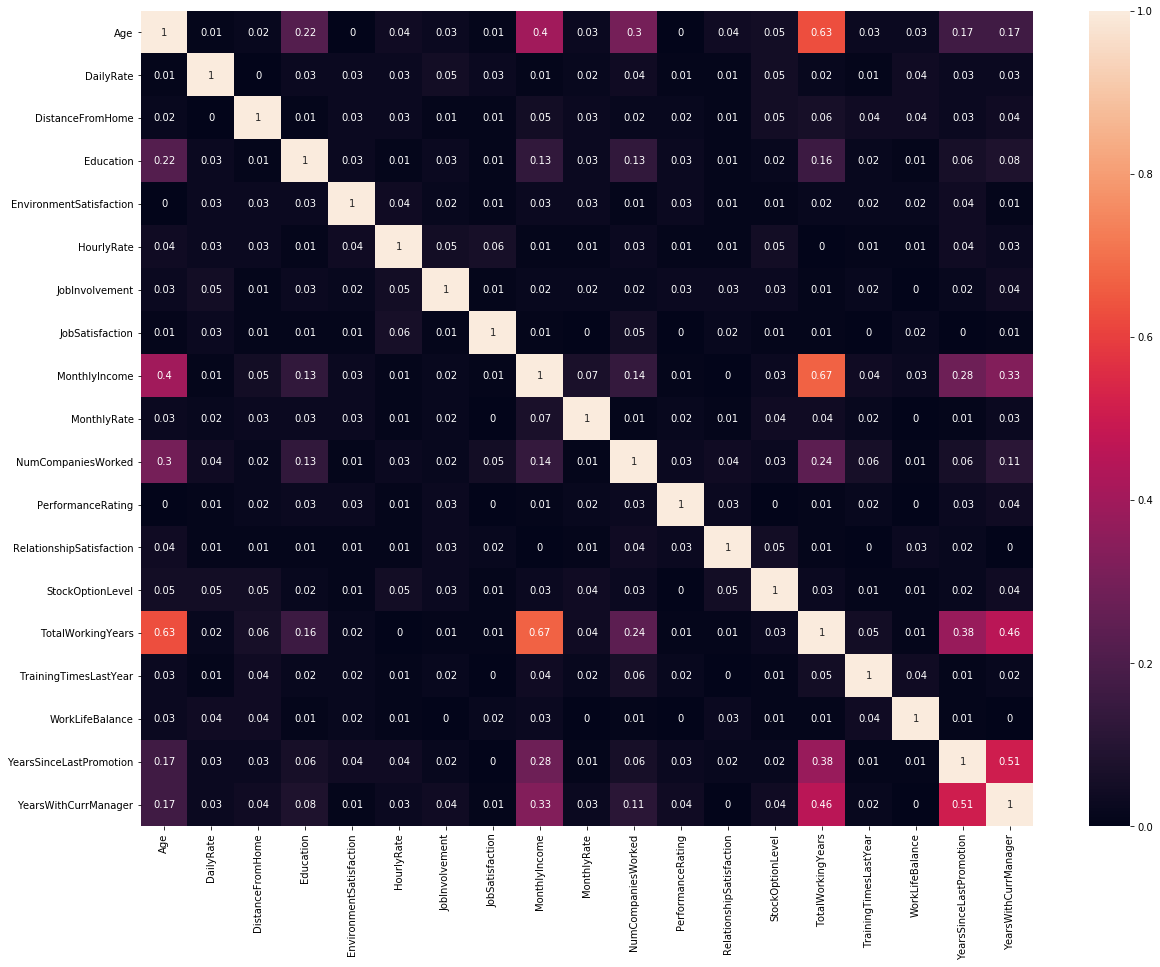

In [372]:
plt.figure(figsize=(20, 15))
sns.heatmap(data_numeric.corr().abs().round(2), annot=True)
plt.show()

In [373]:
data_final=pd.DataFrame(data_numeric.join(data_dummies))
data_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1356 entries, 0 to 1469
Data columns (total 41 columns):
Age                                    1356 non-null int64
DailyRate                              1356 non-null int64
DistanceFromHome                       1356 non-null int64
Education                              1356 non-null int64
EnvironmentSatisfaction                1356 non-null int64
HourlyRate                             1356 non-null int64
JobInvolvement                         1356 non-null int64
JobSatisfaction                        1356 non-null int64
MonthlyIncome                          1356 non-null int64
MonthlyRate                            1356 non-null int64
NumCompaniesWorked                     1356 non-null int64
PerformanceRating                      1356 non-null int64
RelationshipSatisfaction               1356 non-null int64
StockOptionLevel                       1356 non-null int64
TotalWorkingYears                      1356 non-null int64
Training

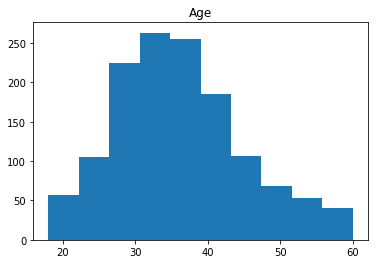

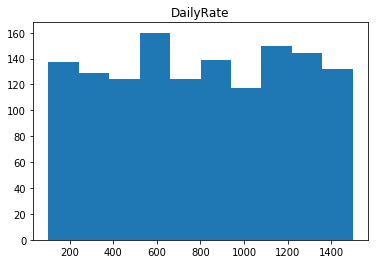

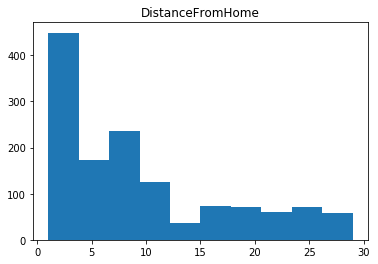

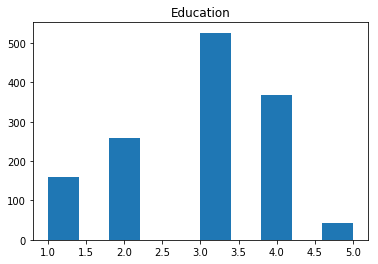

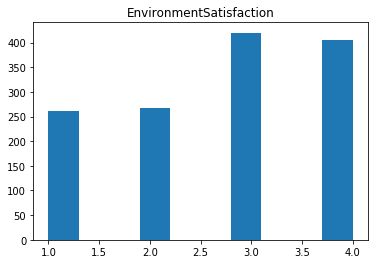

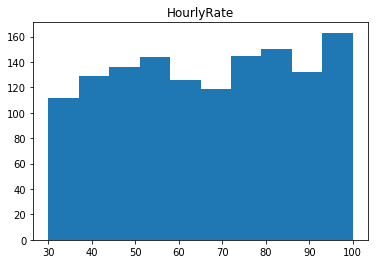

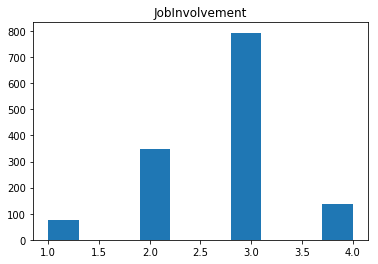

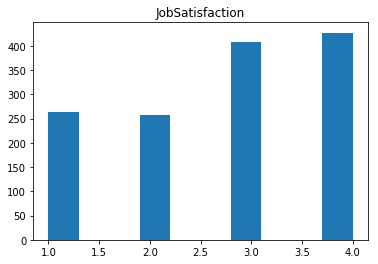

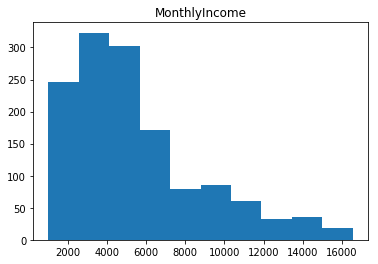

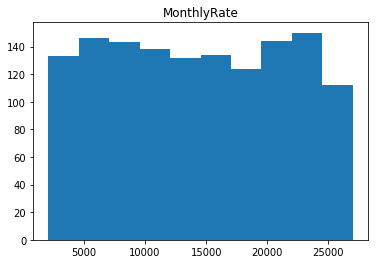

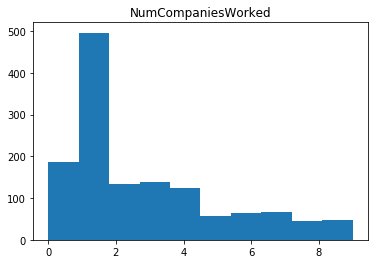

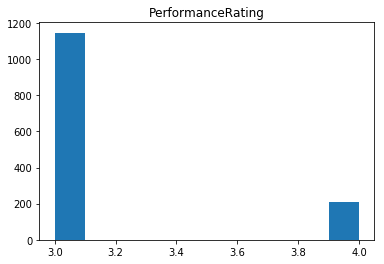

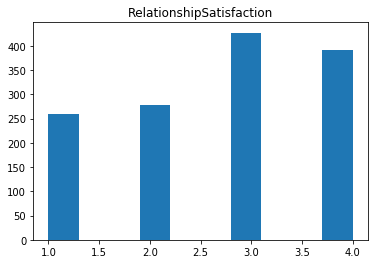

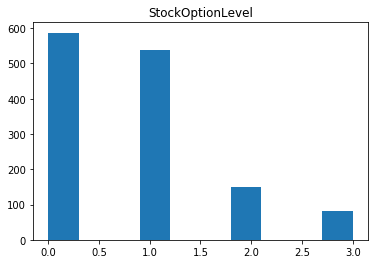

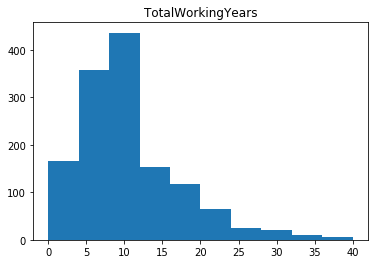

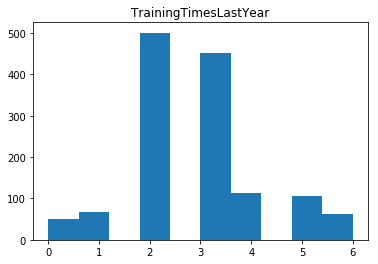

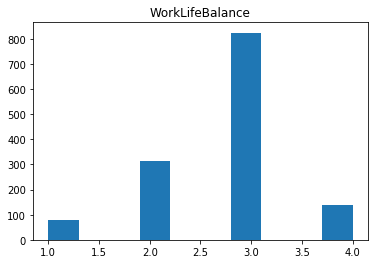

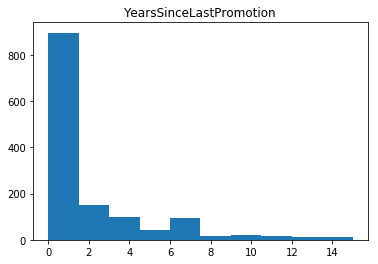

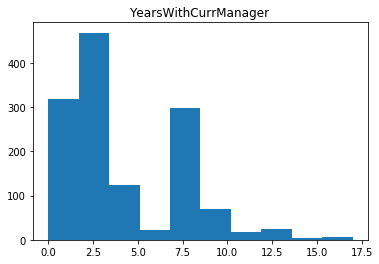

In [374]:
#histogram
for i in data_numeric.columns:
    plt.hist(data_numeric[i])
    plt.title(i)
    plt.show()

In [375]:
data.Attrition.value_counts()/len(data)*100

No     83.877551
Yes    16.122449
Name: Attrition, dtype: float64

if we state that there is no attrition, we will be 84% correct

In [376]:
X=data_final.drop("Attrition_Yes",axis=1)
Y=data_final.Attrition_Yes
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.25,random_state=42)

# Decision Tree (without scaling)

In [377]:
tree1=DecisionTreeClassifier(class_weight="balanced",random_state=42)
grid_search=GridSearchCV(tree1,param_grid={"max_depth":range(3,25),"min_samples_leaf":range(10,150,10)},scoring="roc_auc",cv=5,n_jobs=-1)
grid_search.fit(X,Y)

GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_depth': range(3, 25), 'min_samples_leaf': range(10, 150, 10)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [378]:
print("Best parameters:",grid_search.best_params_)
print("Best score:",grid_search.best_score_.round(2)*100)

Best parameters: {'max_depth': 3, 'min_samples_leaf': 50}
Best score: 73.0


In [379]:
tree2=DecisionTreeClassifier(max_depth=3,min_samples_leaf=50,class_weight="balanced",random_state=42)
tree2.fit(x_train,y_train)

DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=50, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best')

In [380]:
#accuracy score for train and test data
print("Accuracy_Train:",tree2.score(x_train,y_train).round(2)*100)
print("Accuracy_Test:",tree2.score(x_test,y_test).round(2)*100)

Accuracy_Train: 81.0
Accuracy_Test: 75.0


In [381]:
#calculating recall test
ypred1=tree2.predict(x_test)
recall_test=recall_score(y_test,ypred1)
print("Test Recall for DT 1:",recall_test.round(2)*100)


Test Recall for DT 1: 48.0


In [382]:
#calculating recall train
ypred2=tree2.predict(x_train)
recall_test=recall_score(y_train,ypred2)
print("Train Recall for DT 1:",recall_test.round(2)*100)

#recall_train=recall_score(y_test,ypred1)

Train Recall for DT 1: 61.0


In [383]:
#calculating ROC-AUC score
roc_auc1=roc_auc_score(y_test,ypred1).round(2)*100
print("roc_auc_test", roc_auc1)
roc_auc2=roc_auc_score(y_train,ypred2).round(2)*100
print("roc_auc_train", roc_auc2)

roc_auc_test 65.0
roc_auc_train 73.0


In [384]:
# constructing ROC curve 
roc_curve_values=roc_curve(y_test,ypred1)
FPR,TPR,Tresholds=roc_curve_values

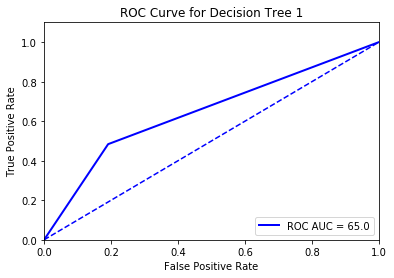

In [385]:
#Plotting ROC curve
plt.figure()
plt.plot(FPR, TPR, color='blue', lw=2, label='ROC AUC = %0.1f'%roc_auc1)
plt.plot([0, 1], [0, 1], color='blue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.1])
plt.title('ROC Curve for Decision Tree 1')
plt.legend(loc="lower right")
plt.show()

# Logistic Regression

In [386]:
formula='Attrition_Yes~'+'+'.join(X.columns.tolist())
formula

'Attrition_Yes~Age+DailyRate+DistanceFromHome+Education+EnvironmentSatisfaction+HourlyRate+JobInvolvement+JobSatisfaction+MonthlyIncome+MonthlyRate+NumCompaniesWorked+PerformanceRating+RelationshipSatisfaction+StockOptionLevel+TotalWorkingYears+TrainingTimesLastYear+WorkLifeBalance+YearsSinceLastPromotion+YearsWithCurrManager+BusinessTravel_Travel_Frequently+BusinessTravel_Travel_Rarely+Department_Research_and_Development+Department_Sales+EducationField_Life_Sciences+EducationField_Marketing+EducationField_Medical+EducationField_Other+EducationField_Technical_Degree+Gender_Male+JobRole_Human_Resources+JobRole_Laboratory_Technician+JobRole_Manager+JobRole_Manufacturing_Director+JobRole_Research_Director+JobRole_Research_Scientist+JobRole_Sales_Executive+JobRole_Sales_Representative+MaritalStatus_Married+MaritalStatus_Single+OverTime_Yes'

In [387]:
logit1=Logit.from_formula(formula=formula,data=data_final).fit()

         Current function value: 0.303884
         Iterations: 35


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [388]:
logit1.summary()

/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:1092: RuntimeWarning: invalid value encountered in sqrt
  bse_ = np.sqrt(np.diag(self.cov_params()))
/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:          Attrition_Yes   No. Observations:                 1356
Model:                          Logit   Df Residuals:                     1315
Method:                           MLE   Df Model:                           40
Date:                Mon, 26 Nov 2018   Pseudo R-squ.:                  0.3359
Time:                        22:54:33   Log-Likelihood:                -412.07
converged:                      False   LL-Null:                       -620.52
                                        LLR p-value:                 3.062e-64
=======================================================================================================
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                             -54.4997   4.97e+06   -1.1e-05      1.000   -9.73e+06    9.73e+06
Age                                    -0.0344      0.014     -2.504      0.012      -0.061      -0.007
DailyRate                              -0.0004      0.000     -1.735      0.083      -0.001    5.05e-05
DistanceFromHome                        0.0478      0.011      4.389      0.000       0.026       0.069
Education                               0.0219      0.090      0.244      0.807      -0.154       0.197
EnvironmentSatisfaction                -0.4324      0.084     -5.131      0.000      -0.598      -0.267
HourlyRate                              0.0032      0.005      0.698      0.485      -0.006       0.012
JobInvolvement                         -0.5207      0.124     -4.189      0.000      -0.764      -0.277
JobSatisfaction                        -0.4049      0.082     -4.921      0.000      -0.566      -0.244
MonthlyIncome                       -1.089e-05    6.2e-05     -0.176      0.861      -0.000       0.000
MonthlyRate                          1.213e-06   1.27e-05      0.096      0.924   -2.36e-05    2.61e-05
NumCompaniesWorked                      0.1942      0.039      5.019      0.000       0.118       0.270
PerformanceRating                      -0.0358      0.254     -0.141      0.888      -0.533       0.462
RelationshipSatisfaction               -0.2736      0.084     -3.256      0.001      -0.438      -0.109
StockOptionLevel                       -0.2124      0.159     -1.332      0.183      -0.525       0.100
TotalWorkingYears                      -0.0537      0.028     -1.937      0.053      -0.108       0.001
TrainingTimesLastYear                  -0.1588      0.073     -2.162      0.031      -0.303      -0.015
WorkLifeBalance                        -0.4218      0.126     -3.340      0.001      -0.669      -0.174
YearsSinceLastPromotion                 0.1962      0.042      4.690      0.000       0.114       0.278
YearsWithCurrManager                   -0.1496      0.041     -3.639      0.000      -0.230      -0.069
BusinessTravel_Travel_Frequently        1.9850      0.419      4.739      0.000       1.164       2.806
BusinessTravel_Travel_Rarely            0.9620      0.384      2.503      0.012       0.209       1.715
Department_Research_and_Development    56.8858   4.97e+06   1.15e-05      1.000   -9.73e+06    9.73e+06
Department_Sales                       23.6129        nan        nan        nan         nan         nan
EducationField_Life_Sciences           -0.7073      0.820     -0.862      0.389      -2.315       0.901
EducationField_Marketing               -0.4779      0.869     -0.550      0.582      -2.182       1.226
EducationField_Medical                 -0.7378      0.819     -0.901      0.368      -2.343       0.868
EducationField_Other                   -0.8390      0.879     -0.954      0.340      -2.563       0.885
EducationField_Te

In [392]:
logit1.get_margeff().summary()

/anaconda3/lib/python3.6/site-packages/statsmodels/discrete/discrete_margins.py:343: RuntimeWarning: invalid value encountered in sqrt
  return cov_me, np.sqrt(np.diag(cov_me))
/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


<class 'statsmodels.iolib.summary.Summary'>
"""
        Logit Marginal Effects       
=====================================
Dep. Variable:          Attrition_Yes
Method:                          dydx
At:                           overall
=======================================================================================================
                                         dy/dx    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Age                                    -0.0032      0.001     -2.713      0.007      -0.006      -0.001
DailyRate                           -3.659e-05   2.08e-05     -1.758      0.079   -7.74e-05     4.2e-06
DistanceFromHome                        0.0045      0.001      4.203      0.000       0.002       0.007
Education                               0.0021      0.009      0.239      0.811      -0.015       0.019
EnvironmentSatisfaction                -0.0405      0.002    -17.614      0.000      -0.045      -0.036
HourlyRate                              0.0003      0.000      0.684      0.494      -0.001       0.001
JobInvolvement                         -0.0488        nan        nan        nan         nan         nan
JobSatisfaction                        -0.0380      0.007     -5.798      0.000      -0.051      -0.025
MonthlyIncome                       -1.021e-06   5.81e-06     -0.176      0.860   -1.24e-05    1.04e-05
MonthlyRate                          1.137e-07   1.19e-06      0.095      0.924   -2.22e-06    2.45e-06
NumCompaniesWorked                      0.0182      0.004      4.867      0.000       0.011       0.026
PerformanceRating                      -0.0034      0.024     -0.142      0.887      -0.050       0.043
RelationshipSatisfaction               -0.0256      0.008     -3.272      0.001      -0.041      -0.010
StockOptionLevel                       -0.0199      0.015     -1.335      0.182      -0.049       0.009
TotalWorkingYears                      -0.0050      0.003     -1.927      0.054      -0.010    8.64e-05
TrainingTimesLastYear                  -0.0149      0.007     -2.204      0.027      -0.028      -0.002
WorkLifeBalance                        -0.0395      0.011     -3.579      0.000      -0.061      -0.018
YearsSinceLastPromotion                 0.0184      0.004      4.592      0.000       0.011       0.026
YearsWithCurrManager                   -0.0140      0.004     -3.571      0.000      -0.022      -0.006
BusinessTravel_Travel_Frequently        0.1861      0.041      4.526      0.000       0.105       0.267
BusinessTravel_Travel_Rarely            0.0902      0.036      2.473      0.013       0.019       0.162
Department_Research_and_Development     5.3322   4.66e+05   1.15e-05      1.000   -9.12e+05    9.12e+05
Department_Sales                        2.2134        nan        nan        nan         nan         nan
EducationField_Life_Sciences           -0.0663      0.077     -0.861      0.389      -0.217       0.085
EducationField_Marketing               -0.0448      0.081     -0.550      0.582      -0.204       0.115
EducationField_Medical                 -0.0692      0.077     -0.900      0.368      -0.220       0.081
EducationField_Other                   -0.0786      0.082     -0.954      0.340      -0.240       0.083
EducationField_Technical_Degree         0.0140      0.078      0.179      0.858      -0.140       0.168
Gender_Male                             0.0396      0.018      2.246      0.025       0.005       0.074
JobRole_Human_Resources                 5.4632   4.66e+05   1.17e-05      1.000   -9.12e+05    9.12e+05
JobRole_Laboratory_Technician           0.1402      0.045      3.092      0.002       0.051       0.229
JobRole_Manager                         0.1395      0.096      1.446      0.148      -0.050       0.329
JobRole_Manufacturing_Director          0.0198      0.050      0.394      0.694      -0.079       0.118
JobRole_Research_D

From the summary and from marginal effects, p-value for WorkLifeBalance is less than 0.05, so we can conclude that there is a significant relationship between WorkLifeBalance and Attrition. Incremental increase in WorkLifeBalance will decrease the probability of leaving the company, on average by 3.28% (0.0328*100%) when other factors are held constant.

# Model 4. Not Scaled Logistic Regression

In [393]:
grid_search1=GridSearchCV(LogisticRegression(random_state=42),
                         param_grid={"C":np.linspace(0.0001,50,10),"class_weight":[None,"balanced"]},
                         scoring="roc_auc",cv=5,n_jobs=-1)
grid_search1.fit(X,Y)

GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'C': array([1.00000e-04, 5.55564e+00, 1.11112e+01, 1.66667e+01, 2.22223e+01,
       2.77778e+01, 3.33334e+01, 3.88889e+01, 4.44445e+01, 5.00000e+01]), 'class_weight': [None, 'balanced']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [394]:
print(grid_search1.best_params_)
best=list(grid_search1.best_params_.values())[0]
print("Best score:", grid_search1.best_score_.round(2)*100)

{'C': 33.33336666666667, 'class_weight': 'balanced'}
Best score: 83.0


In [395]:
logit1=LogisticRegression(C=best,random_state=42,class_weight="balanced")
logit1.fit(x_train,y_train)

LogisticRegression(C=33.33336666666667, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=42,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [396]:
print("Train:",logit1.score(x_train,y_train).round(2)*100)
print("Test:",logit1.score(x_test,y_test).round(2)*100)
ypred3=logit1.predict(x_test)
print("recall_test:",recall_score(y_test,ypred3).round(2)*100)
roc_auc3=roc_auc_score(y_test,ypred3).round(2)*100
print("roc_auc_test:",roc_auc3)
ypred4=logit1.predict(x_train)
print("recall_train:",recall_score(y_train,ypred4).round(2)*100)
roc_auc4=roc_auc_score(y_test,ypred3).round(2)*100
print("roc_auc_train:",roc_auc4)

Train: 78.0
Test: 75.0
recall_test: 81.0
roc_auc_test: 77.0
recall_train: 79.0
roc_auc_train: 77.0


In [397]:
# constructing ROC curve
roc_curve_values2=roc_curve(y_test,ypred3)
FPR2,TPR2,Tresholds2=roc_curve_values2

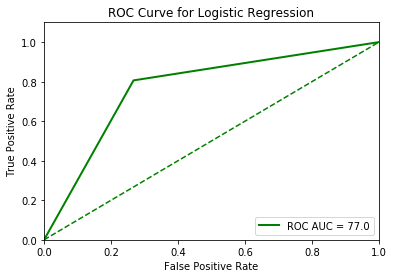

In [398]:
#Plotting ROC curve
plt.figure()
plt.plot(FPR2, TPR2, color='green', lw=2, label='ROC AUC = %0.1f'%roc_auc3)
plt.plot([0, 1], [0, 1], color='green', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.1])
plt.title('ROC Curve for Logistic Regression')
plt.legend(loc="lower right")
plt.show()

# Result Summary

In [472]:
print("Logit Results")
print("Train:",logit1.score(x_train,y_train).round(2)*100)
print("Test:",logit1.score(x_test,y_test).round(2)*100)
ypred3=logit1.predict(x_test)
print("recall_test:",recall_score(y_test,ypred3).round(2)*100)
roc_auc3=roc_auc_score(y_test,ypred3).round(2)*100
print("roc_auc_test:",roc_auc3)
ypred4=logit1.predict(x_train)
print("recall_train:",recall_score(y_train,ypred4).round(2)*100)
roc_auc4=roc_auc_score(y_test,ypred3).round(2)*100
print("roc_auc_train:",roc_auc4)
print("\n","---------------------------------------")
print("Tree Results")
print("Accuracy_Train:",tree2.score(x_train,y_train).round(2)*100)
print("Accuracy_Test:",tree2.score(x_test,y_test).round(2)*100)
print("Test Recall for DT 1:",recall_test.round(2)*100)
print("roc_auc_test", roc_auc1)
roc_auc2=roc_auc_score(y_train,ypred2).round(2)*100
print("roc_auc_train", roc_auc2)
print("Train Recall for DT 1:",recall_test.round(2)*100)

Logit Results
Train: 78.0
Test: 75.0
recall_test: 81.0
roc_auc_test: 77.0
recall_train: 79.0
roc_auc_train: 77.0

 ---------------------------------------
Tree Results
Accuracy_Train: 81.0
Accuracy_Test: 75.0
Test Recall for DT 1: 61.0
roc_auc_test 65.0
roc_auc_train 73.0
Train Recall for DT 1: 61.0


In [400]:
# we can see that roc_auc test score is higher for logistic regression (77>65), so it is a better model

# Important features

In [460]:
#important features are the ones, whos p-value is smaller than 0.05

In [461]:
#imp_feature=["Age", "DistanceFromHome", "EnvironmentSatisfaction", "JobSatisfaction", "NumCompaniesWorked", "RelationshipSatisfaction",
#"TrainingTimesLastYear", "WorkLifeBalance", "YearsSinceLastPromotion", "YearsWithCurrManager", 
#"BusinessTravel_Travel_Frequently", "BusinessTravel_Travel_Rarely", "Gender_Male", "JobRole_Laboratory_Technician",
#"MaritalStatus_Single", "OverTime_Yes"]

In [462]:
model = sm.OLS(Y,X)
results = model.fit()

In [463]:
pvals = results.pvalues
#coeff = results.params
#results_df = pd.DataFrame({"pvals":pvals, "coeff":coeff,})
#results_df = results_df[["coeff","pvals"]]
results_df = pd.DataFrame({"pvals":pvals})
results_df = results_df[["pvals"]]
results_df.head()

,pvals
Age,9.835489e-03
DailyRate,1.250381e-01
DistanceFromHome,2.030735e-04
Education,6.193434e-01
EnvironmentSatisfaction,5.579002e-07


In [464]:
results_1=results_df[results_df.pvals<0.05]
results_1.head()

,pvals
Age,9.835489e-03
DistanceFromHome,2.030735e-04
EnvironmentSatisfaction,5.579002e-07
JobInvolvement,1.158540e-05
JobSatisfaction,2.083970e-06


In [469]:
imp_list=(results_1.index.values.tolist())
print(imp_list)

['Age', 'DistanceFromHome', 'EnvironmentSatisfaction', 'JobInvolvement', 'JobSatisfaction', 'NumCompaniesWorked', 'RelationshipSatisfaction', 'WorkLifeBalance', 'YearsSinceLastPromotion', 'YearsWithCurrManager', 'BusinessTravel_Travel_Frequently', 'BusinessTravel_Travel_Rarely', 'Department_Research_and_Development', 'Department_Sales', 'Gender_Male', 'JobRole_Human_Resources', 'JobRole_Laboratory_Technician', 'JobRole_Sales_Representative', 'MaritalStatus_Single', 'OverTime_Yes']


In [470]:
new_data_final_1=data_final.loc[:,['Age', 'DistanceFromHome', 'EnvironmentSatisfaction', 'JobInvolvement', 'JobSatisfaction', 'NumCompaniesWorked', 'RelationshipSatisfaction', 'WorkLifeBalance', 'YearsSinceLastPromotion', 'YearsWithCurrManager', 'BusinessTravel_Travel_Frequently', 'BusinessTravel_Travel_Rarely', 'Department_Research_and_Development', 'Department_Sales', 'Gender_Male', 'JobRole_Human_Resources', 'JobRole_Laboratory_Technician', 'JobRole_Sales_Representative', 'MaritalStatus_Single', 'OverTime_Yes']]
new_data_final_1.head()

,Age,DistanceFromHome,EnvironmentSatisfaction,JobInvolvement,JobSatisfaction,NumCompaniesWorked,RelationshipSatisfaction,WorkLifeBalance,YearsSinceLastPromotion,YearsWithCurrManager,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,Department_Research_and_Development,Department_Sales,Gender_Male,JobRole_Human_Resources,JobRole_Laboratory_Technician,JobRole_Sales_Representative,MaritalStatus_Single,OverTime_Yes
0,41,1,2,3,4,8,1,1,0,5,0,1,0,1,0,0,0,0,1,1
1,49,8,3,2,2,1,4,3,1,7,1,0,1,0,1,0,0,0,0,0
2,37,2,4,2,3,6,2,3,0,0,0,1,1,0,1,0,1,0,1,1
3,33,3,4,3,3,1,3,3,3,0,1,0,1,0,0,0,0,0,0,1
4,27,2,1,3,2,9,4,3,2,2,0,1,1,0,1,0,1,0,0,0


In [ ]:
plt.figure(figsize=(10,6))
plt.bar(sig_marg_eff["Unnamed: 0"],sig_marg_eff["dy/dx"])
plt.xticks(rotation=90)
plt.title("Feature importances (stat sig variables)")
plt.show()

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


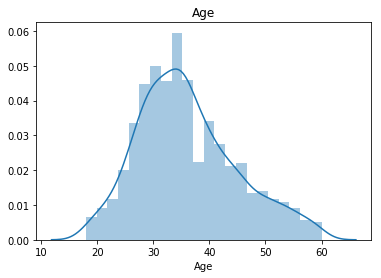

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


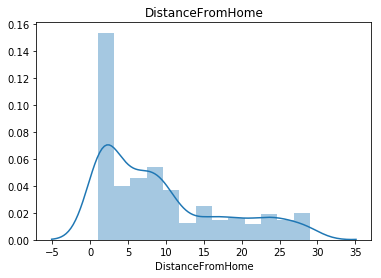

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


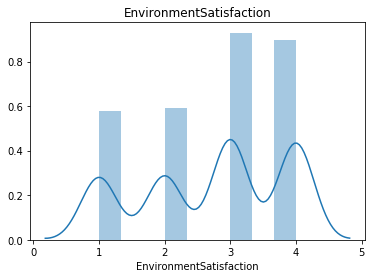

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


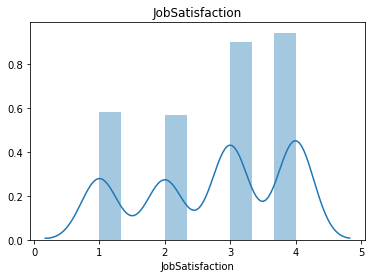

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


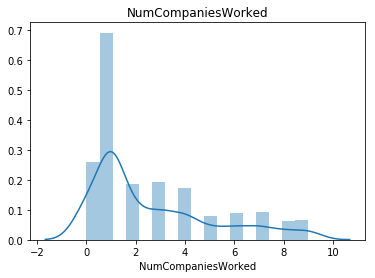

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


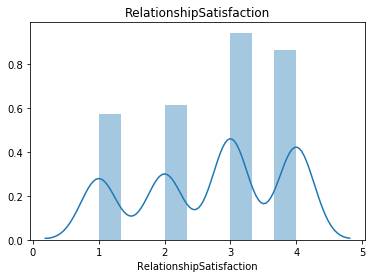

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


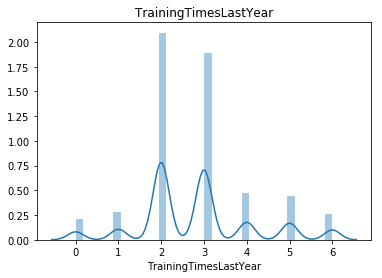

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


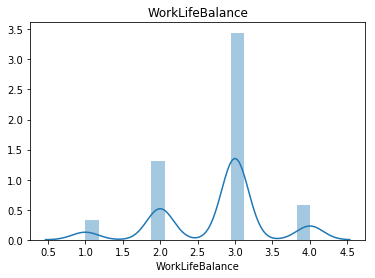

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


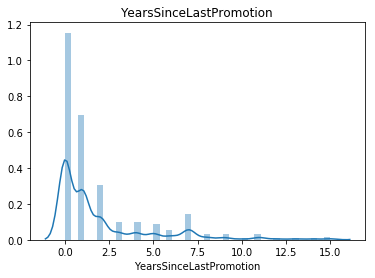

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


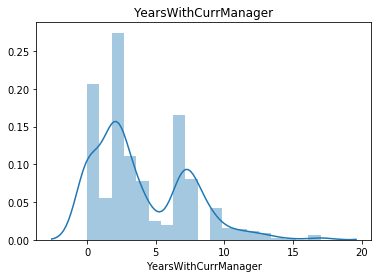

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


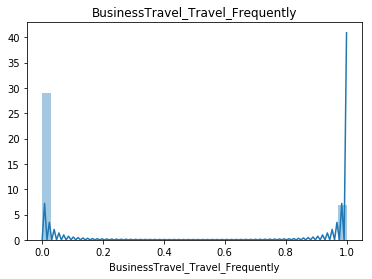

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


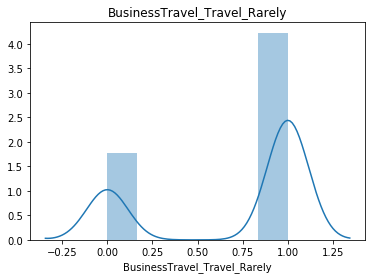

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


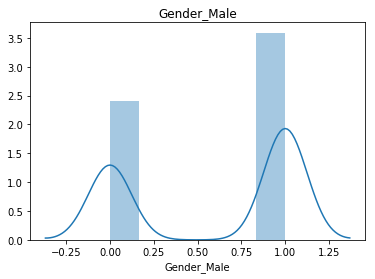

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


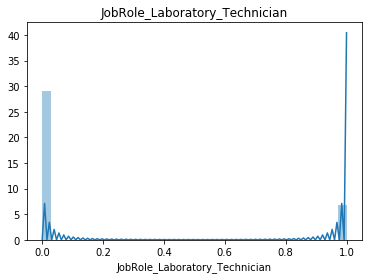

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


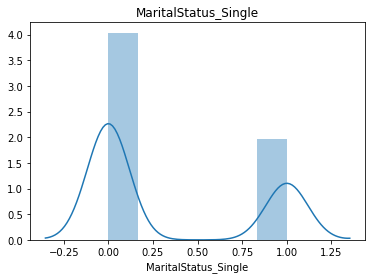

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


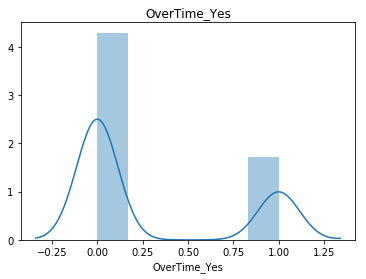

In [471]:
#plotting important features
for i in new_data_final:
    sns.distplot(new_data_final[i])
    plt.title(i)
    plt.show()